In [ ]:
from dataset import NYUDEPTHV2
from model import UNet
from loss import mde_loss
from utils import test_model
from utils import predict
from utils import preprocess_fn

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader



In [ ]:
#folder = "train"
folder = "val/official"
root = "/media/nurbano/Datos12/Datasets/nyudepthv2"

In [ ]:
path = root + "/" + folder 
filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))

filelist.sort()
data = {
    "h5": [x for x in filelist if x.endswith(".h5")]
}

df = pd.DataFrame(data)

df.head()

,h5
0,/media/nurbano/Datos12/Datasets/nyudepthv2/val...
1,/media/nurbano/Datos12/Datasets/nyudepthv2/val...
2,/media/nurbano/Datos12/Datasets/nyudepthv2/val...
3,/media/nurbano/Datos12/Datasets/nyudepthv2/val...
4,/media/nurbano/Datos12/Datasets/nyudepthv2/val...


In [ ]:
#Take a 50k split of the dataset
#df2=df.sample(n=50000, replace=True).reset_index(drop="true")
df2= df

In [ ]:
root = "/media/nurbano/Datos12/Datasets/nyudepthv2"
train_folder= "train"
path = root + "/" + train_folder
print(path)
filelist = []

for root, dirs, files in os.walk(path):
    for file in files:
        filelist.append(os.path.join(root, file))
        #print(file)
filelist.sort()
data = {
    "h5": [x for x in filelist if x.endswith(".h5")]
}


df_train = pd.DataFrame(data)

df_train.head()

/media/nurbano/Datos12/Datasets/nyudepthv2/train


,h5
0,/media/nurbano/Datos12/Datasets/nyudepthv2/tra...
1,/media/nurbano/Datos12/Datasets/nyudepthv2/tra...
2,/media/nurbano/Datos12/Datasets/nyudepthv2/tra...
3,/media/nurbano/Datos12/Datasets/nyudepthv2/tra...
4,/media/nurbano/Datos12/Datasets/nyudepthv2/tra...


In [ ]:
tran_test = transforms.Compose([transforms.Resize([224,224])])

dset_test = NYUDEPTHV2(path, df2.reset_index(drop="true"),  transform = tran_test, transform2 = None)
#dset_test = NYUDEPTHV2(path, df2[int(df2.h5.size*0.99):].reset_index(drop="true"),  transform = tran_test, transform2 = None)

In [ ]:
dset_train= NYUDEPTHV2(path, df_train.reset_index(drop="true"),  transform = tran_test, transform2 = None)

In [ ]:
len(dset_test), len(dset_train)

(654, 47584)

In [ ]:
test_dataloader= DataLoader(dset_test, batch_size=32, shuffle=True, num_workers=12)
train_dataloader= DataLoader(dset_train, batch_size=32, shuffle=True, num_workers=12)


torch.Size([3, 224, 224]) torch.Size([1, 224, 224]) tensor(1.7765) tensor(0.2377) torch.float32 torch.float32


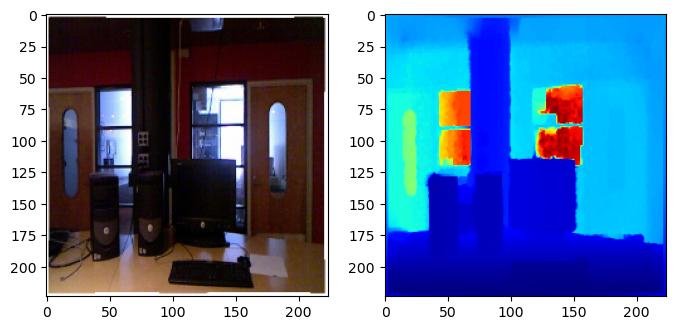

In [ ]:
im, de = dset_test[10]
print(im.shape, de.shape, de.max(), de.min(), im.dtype, de.dtype)

cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="black")
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow((im.squeeze().permute(1,2,0) + 1.0)/2.0)
ax[1].imshow((de.squeeze() + 1.0)/2.0, cmap= cmap)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = UNet().to(device)

In [ ]:
PATH_MODEL= "./models/mde_v1.pth"
#PATH_MODEL= "model.pth"


In [ ]:
checkpoint = torch.load(PATH_MODEL)
model.load_state_dict(checkpoint, strict= False)

/tmp/ipykernel_47723/2488044976.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH_MODEL)


_IncompatibleKeys(missing_keys=[], unexpected_keys=['down5.maxpool_conv.1.double_conv.0.weight', 'down5.maxpool_conv.1.double_conv.1.weight', 'down5.maxpool_conv.1.double_conv.1.bias', 'down5.maxpool_conv.1.double_conv.1.running_mean', 'down5.maxpool_conv.1.double_conv.1.running_var', 'down5.maxpool_conv.1.double_conv.1.num_batches_tracked', 'down5.maxpool_conv.1.double_conv.3.weight', 'down5.maxpool_conv.1.double_conv.4.weight', 'down5.maxpool_conv.1.double_conv.4.bias', 'down5.maxpool_conv.1.double_conv.4.running_mean', 'down5.maxpool_conv.1.double_conv.4.running_var', 'down5.maxpool_conv.1.double_conv.4.num_batches_tracked', 'up3.up.weight', 'up3.up.bias', 'up3.conv.double_conv.0.weight', 'up3.conv.double_conv.1.weight', 'up3.conv.double_conv.1.bias', 'up3.conv.double_conv.1.running_mean', 'up3.conv.double_conv.1.running_var', 'up3.conv.double_conv.1.num_batches_tracked', 'up3.conv.double_conv.3.weight', 'up3.conv.double_conv.4.weight', 'up3.conv.double_conv.4.bias', 'up3.conv.doubl

In [ ]:
model.eval()
PATH_MODEL

'./models/mde_v1.pth'

In [ ]:
rmse = test_model(model, test_dataloader, device)
print("Test: ", "RMSE: ",rmse)

Test:  RMSE:  3.713972568511963


In [ ]:
from metrics import evaluate_depth

In [ ]:
eval = evaluate_depth(test_dataloader, model, device)

hola


Evaluando:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
print(eval)

In [ ]:
for k,v in eval.items():
    print(f"{k}: {v:.4f}")

In [ ]:
rmse = test_model(model, train_dataloader, device)
print("Test: ", "RMSE: ",rmse)



KeyboardInterrupt: 

GT min: 0.16791239380836487 GT max: 0.8098852038383484 GT mean: 0.4922981262207031
Pred min: -0.003666297998279333 Pred max: 0.30410394072532654 Pred mean: 0.15437929332256317


(-0.5, 223.5, 223.5, -0.5)

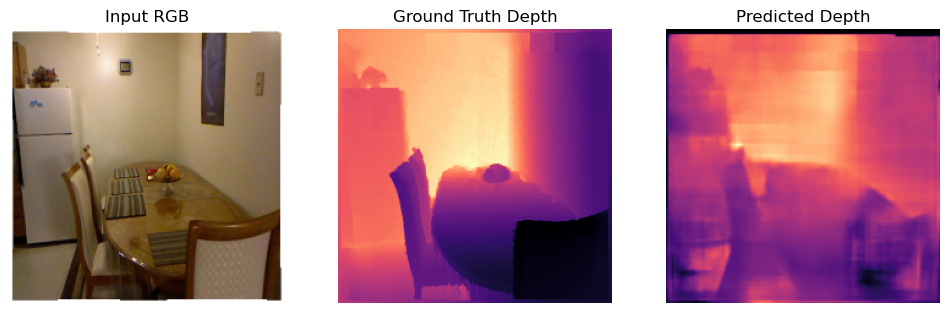

In [ ]:
im, dm = dset_test[230]
print("GT min:", dm.min().item(), "GT max:", dm.max().item(), "GT mean:", dm.mean().item())
de_p=predict(im, model, device)
print("Pred min:", de_p.min().item(), "Pred max:", de_p.max().item(), "Pred mean:", de_p.mean().item())
cmap = plt.get_cmap("magma").copy()
cmap.set_bad(color="black")


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].set_title("Input RGB")
ax[0].imshow((im.permute(1,2,0) + 1.0)/2.0)
ax[0].axis("off")
ax[1].set_title("Ground Truth Depth")
ax[1].imshow((dm.squeeze() + 1.0)/2.0, cmap= cmap)
ax[1].axis("off")
ax[2].set_title("Predicted Depth")
ax[2].imshow((de_p.squeeze() + 1.0)/2.0, cmap= cmap)
ax[2].axis("off")

In [ ]:
FPS= []
DEVICE= []

## Inference on GPU

In [ ]:
device="cuda:0"
dummy_input = torch.randn(1, 3,224,224).to(device)
model.to(device)
# INIT LOGGERS
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn/1000)
print("FPS:", 1000/mean_syn)
FPS.append(1000/mean_syn)
DEVICE.append("GPU")

0.0030223807811737063
FPS: 330.86499432135145


## Inference on CPU

In [ ]:
import time
device= "cpu"
dummy_input = torch.randn(1, 3,224,224, dtype=torch.float).to(device)
model.to(device)

repetitions = 1
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _ = model(dummy_input)
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        st = time.time()
        _ = model(dummy_input)
        et = time.time()
        # WAIT FOR GPU SYNC

        curr_time = et-st
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)
print("FPS:", 1/mean_syn)

FPS.append(1/mean_syn)
DEVICE.append("CPU")

0.041521549224853516
FPS: 24.083879784558494


Text(0.5, 1.0, 'Inference')

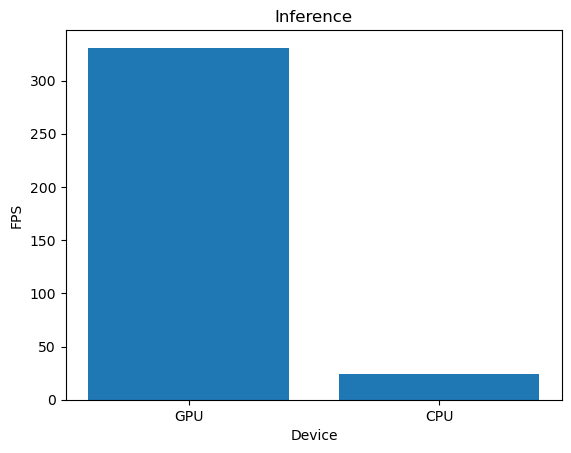

In [ ]:
plt.bar(DEVICE,FPS)
plt.xlabel("Device")
plt.ylabel("FPS")
plt.title("Inference")

In [ ]:
img_path= "/home/nurbano/Dropbox/depht_estimation/hogar_casa.jpg"

## Infer a custom image

In [ ]:
from PIL import Image

In [ ]:
im = np.array(Image.open(img_path).resize((224,224)), dtype=np.float32)
im = np.transpose(im, (2, 0, 1))
im = (im - np.min(im))/(np.max(im) - np.min(im))
im = (im - 0.5)*2.0
im = torch.from_numpy(im[0:3])

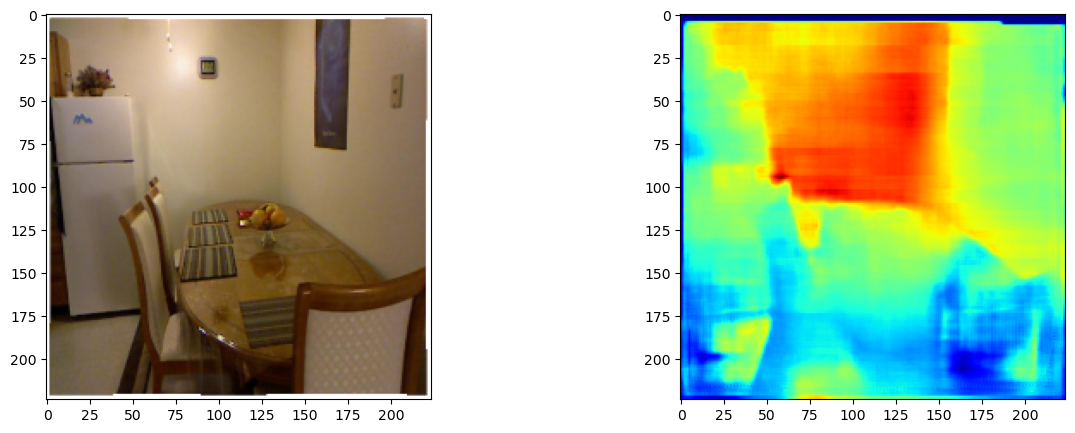

In [ ]:
de_p=predict(im, model, device)
cmap = plt.get_cmap("jet").copy()
cmap.set_bad(color="black")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow((im.permute(1,2,0) + 1.0)/2.0)

ax[1].imshow((de_p.squeeze() + 1.0)/2.0, cmap= cmap)

In [ ]:
from IPython import display
import cv2

In [ ]:
np.asarray(im.squeeze()).shape

(3, 224, 224)

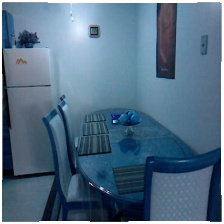

In [ ]:
_,ret_array = cv2.imencode('.jpg', np.asarray((((im/2)+0.5)*255).squeeze()).transpose((1,2,0)) )
i= display.Image(data=ret_array)
display.display(i)